# Polarization and Perception in Social Networks
In today's society, there is much research into the polarization of opinions, but less into the polarization of perceptions. Are the opinions of our community members really as extreme as we think they are? This research sought to simulate opinion exposure and subsequent perception development, to understand how interactions with our peers influence our understanding of society-wide opinion. <br>
This code was written by Samm Kaiser, a fourth year Math + Computer Science student at Washington University in Saint Louis, under the mentorship of Professor Yevgeniy (Eugene) Vorobeychik. <br>
This notebook walks through our basic methodology and thinking, with potential extensions at the end. Our hope is that someone will pick up where we left off, and continue characterizing perceptions of opinions in social networks. If you have any questions, please email sammkaiser@wustl.edu.

## Getting started
We will begin by importing relevant packages and randomly generating our network. This research used the [Barabasi-Albert model](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) for social networks.

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import tee
import math

In [15]:
seed = 14
n = 500
m = 5
network = nx.barabasi_albert_graph(n, m, seed)

Next, we initialize the set of opinions for our network. These opinions have a random uniform distribution. We then place the opinions in a dictionary, and use the Networkx set_node_attributes function to assign each opinion to a respective node. This is one area where the code can be improved - Networkx node attribute functions are very slow to run. This is not a huge issue here, but slows down simulations later in the code. <br>
The range of initial opinions is [-1.0, 1.0], and we will treat higher magnitudes as more extreme opinions. <br>

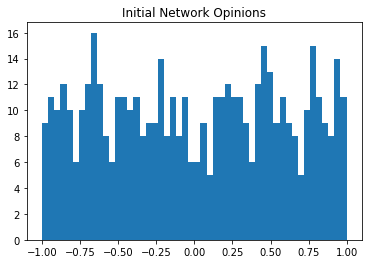

In [16]:
initial_opinions = np.random.uniform(-1.0, 1.0, n)
opinions = {}
for node in network:
    opinions[node] = initial_opinions[node]
        
#Assign opinions to nodes
nx.set_node_attributes(network, opinions, "opinion")

plt.figure()
plt.hist(initial_opinions, bins = 50)
plt.title("Initial Network Opinions")
plt.show()

We will now define two more dictionaries: one to track the opinions each node is exposed to, and one to track the number of times a given opinion has been exposed. These will be useful for bookkeeping later on.

In [17]:
keys = network.nodes()
opinions_exposed_to = {node: [] for node in keys}
nx.set_node_attributes(network, opinions_exposed_to, "opinions_exposed_to")

opinion_frequency = {}
#Set to zero initially
for opinion in opinions:
    opinion_frequency[opinion] = 0
nx.set_node_attributes(network, opinion_frequency, "opinion_frequency")

## Probability Functions
Now we define two probability functions. We use these functions to assign exposure probabilities to each opinion. <br>
The first function defines a preferential attachment-style probability function, and the second defines a uniform Gaussian function. <br>
Throughout this notebook, we will use the preferential attachment function, but this code can easily be refactored to use the Gaussian function. Note: The Gaussian function does not account for repeat exposure. 

In [18]:
def pref_attach_opinion(network, sample, k):
    #get the opinions 
    opinions = {}
    opinion = 0
    #Making this list because we can only iterate through the network once
    people = []
    for person in sample:
        opinion = network.nodes[person]['opinion']
        opinions[person] = opinion
        people.append(person)
    #Now we need to select
    opinions_absolute_values = [abs(op) for op in list(opinions.values())]
    opinion_sum = sum(opinions_absolute_values)
    opinions_probabilities = []
    probability = 0
    
    for person in people:
        their_opinion_abs = abs(network.nodes[person]['opinion'])
        their_opinion_frequency = network.nodes[person]['opinion_frequency']
        if their_opinion_frequency >= 1: #Opinion has been seen at least once before
            probability = math.log(their_opinion_frequency*their_opinion_abs)/(opinion_sum)
        else: #Opinion has not been seen yet
            probability = their_opinion_abs/(opinion_sum)
        opinions_probabilities.append(probability)
        
    
    opinions_exposed = random.choices(list(opinions.values()), weights=opinions_probabilities, k=k)
    
    return opinions_exposed

#uniform probability function
def uniform_opinion(network, sample, k):
    #get the opinions
    opinions = {}
    opinion = 0
    for person in sample:
        opinion = network.nodes[person]['opinion']
        opinions[person] = opinion
       
    #opinions have equal weight
    opinions_exposed = random.choices(list(opinions.values()),  k=k)
    return opinions_exposed

## Simulating opinion exposure
We now define a function to simulate opinion exposure. As mentioned above, this function uses the preferential attachment probability function, with a uniform random distribution for initial opinions and perceptions. <br>
This function takes in a network, a set of opinions, the number of opinions to expose per round, and how many opinions a node can remember at one time. 

In [21]:
def simulate_1(network, num_rounds, opinions_per_round, opinion_memory):
    
    #visualize initial perceptions
    print("Perception Shift")
    print("Opinion Exposure Method: Preferential")
    print("Initial Opinions: Random Uniform")
    print("Initial Perceptions = Initial Opinions")
    plt.figure()
    plt.hist(initial_opinions, bins=100)
    plt.show()
    
    perceptions = {}
    
    for node in network:
        #rounds of exposure
        new_opinions_exposed_to = []
        for i in range(0, num_rounds):
            #get the neighbors - have to do this in every round bc it returns an iterator
            neighbors = network.neighbors(node)
            opinions_exposed = pref_attach_opinion(network, neighbors, opinions_per_round)
            exposure_history = nx.get_node_attributes(network, "opinions_exposed_to")
            opinion_frequencies = nx.get_node_attributes(network, "opinion_frequency")
            exposure_history_this_node = exposure_history[node]
            for new_opinion in opinions_exposed:
                exposure_history_this_node.insert(0, new_opinion)  
                new_opinion_frequency = 1 + opinion_frequencies[node]
                opinion_frequencies[node] = new_opinion_frequency
        
            if len(exposure_history_this_node) > opinion_memory: #More than ten opinions stored
                #Want to keep the most recent ones
                exposure_history_this_node = exposure_history_this_node[0:opinion_memory]
            
        exposure_history[node] = exposure_history_this_node
        nx.set_node_attributes(network, exposure_history, "opinions_exposed_to")
        nx.set_node_attributes(network, opinion_frequencies, "opinion_frequency")
        #Take the average opinion, based on total stored exposed opinions
        average_opinion = sum(exposure_history[node])/len(exposure_history[node])
        #Update that nodes perception
        perceptions[node] = average_opinion
    
    #visualize final perceptions
    plt.figure()
    plt.hist(list(perceptions.values()), bins=100)
    plt.show()
    
    #get the average perception magnitude
    perception_abs = [abs(per) for per in list(perceptions.values())]
    
    average_perception = sum(perception_abs)/len(perception_abs)
    
    return num_rounds, average_perception

Perception Shift
Opinion Exposure Method: Preferential
Initial Opinions: Random Uniform
Initial Perceptions = Initial Opinions


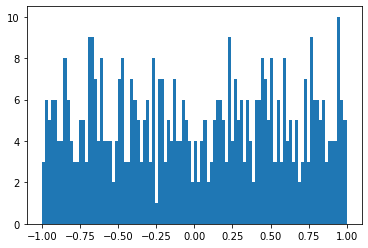

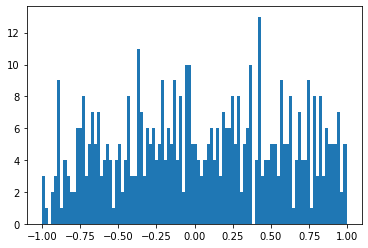

(40, 0.46495491389159554)

In [22]:
simulate_1(network, 40, 1, 10)

We will use the following helper function later to calculate the average opinion of the network. 

In [23]:
def get_average_opinion_abs(network):
    opinions = nx.get_node_attributes(network, "opinion")
    opinion_sum = 0
    num = 0
    for person in opinions:
        opinion_sum += abs(network.nodes[person]['opinion'])
        num += 1
    return opinion_sum/num

## Simulating over time
The following function runs the simulation many times, graphing the average perception vs. the number of rounds of exposure. We provide the average opinion (which is static) in this graph to visualize the divergence between average perception and average opinion. <br> <br>
Because each simulation alters the network, we need to reset the network to the initial opinions before each simulation. The following simulation function is identical to the one above, but begins by re-intializing the same network every time. 

In [25]:
def simulate_2(network, num_rounds, opinions_per_round, opinion_memory):
    
    #visualize initial perceptions
    #print("Perception Shift")
    #print("Opinion Exposure Method: Preferential")
    #print("Initial Opinions: Random Uniform")
    #print("Initial Perceptions = Initial Opinions")
    #plt.figure()
    #plt.hist(initial_opinions, bins=100)
    #plt.show()
    
    
    #reinitialize the network perceptions
    initial_perceptions = {}
    opinions = nx.get_node_attributes(network, "opinion")
    for node in network:
        initial_perceptions[node] = opinions[node]
        
    #Assign opinions and perceptions to nodes
    nx.set_node_attributes(network, initial_perceptions, "perception")

    #Need to reset the memory and frequencies as well
    keys = network.nodes()
    opinions_exposed_to = {node: [] for node in keys}
    nx.set_node_attributes(network, opinions_exposed_to, "opinions_exposed_to")

    opinion_frequency = {}
    #Set to zero initially
    for opinion in opinions:
        opinion_frequency[opinion] = 0
    nx.set_node_attributes(network, opinion_frequency, "opinion_frequency")
        
    perceptions = {}
    #rounds of exposure
    for node in network:
        #rounds of exposure
        new_opinions_exposed_to = []
        for i in range(0, num_rounds):
            #get the neighbors - have to do this in every round bc it returns an iterator
            neighbors = network.neighbors(node)
            opinions_exposed = pref_attach_opinion(network, neighbors, opinions_per_round)
        
            exposure_history = nx.get_node_attributes(network, "opinions_exposed_to")
            opinion_frequencies = nx.get_node_attributes(network, "opinion_frequency")
            exposure_history_this_node = exposure_history[node]
            for new_opinion in opinions_exposed:
                exposure_history_this_node.insert(0, new_opinion)  
                new_opinion_frequency = 1 + opinion_frequencies[node]
                opinion_frequencies[node] = new_opinion_frequency
        
            if len(exposure_history_this_node) > opinion_memory: #More than ten opinions stored
                #Want to keep the most recent ones
                exposure_history_this_node = exposure_history_this_node[0:opinion_memory]

            
        exposure_history[node] = exposure_history_this_node
        nx.set_node_attributes(network, exposure_history, "opinions_exposed_to")
        nx.set_node_attributes(network, opinion_frequencies, "opinion_frequency")
        #Take the average opinion, based on total stored exposed opinions
        #Use absolute values here
        exposure_history_abs = [abs(exp) for exp in exposure_history_this_node]
        average_opinion = sum(exposure_history_abs)/len(exposure_history_abs)
        #Update that nodes perception
        perceptions[node] = average_opinion
    
    #Update the perceptions in the network
    nx.set_node_attributes(network, perceptions, 'perception')
    
    #visualize final perceptions
    #plt.figure()
    #plt.hist(list(perceptions.values()), bins=100)
    #plt.show()
    
    average_perception = sum(perceptions.values())/len(perceptions)

    return num_rounds, average_perception

In [26]:
def simulate_over_time(network, max_num_rounds, opinions_per_round, opinion_memory):
    i = 1    
    average_opinion = get_average_opinion_abs(network)
    perceptions = [average_opinion]
    rounds = [0]
    
    print("Average Perception vs. Number of Exposure Rounds")
    print("Opinion Exposure Method: Preferential")
    print("Initial Opinions: Random Uniform")
    print("Initial Perceptions = Initial Opinions")
    #run the simulation with an increasing number of exposure rounds
    while (i <= max_num_rounds):
        num_rounds, average_perception = simulate_2(network, i, opinions_per_round, opinion_memory)
        rounds.append(num_rounds)
        perceptions.append(abs(average_perception))
        i += 1
    
    #visualize how the average perception changes with the number of rounds, compare to average opinion
    plt.figure()
    plt.plot(rounds, perceptions)
    opinions_plot = [average_opinion for i in range(num_rounds + 1)]
    plt.plot(rounds, opinions_plot)
    plt.title("Average Perception vs. Number of Rounds")
    plt.xlabel("Number of Rounds")
    plt.ylabel("Average Perception at Conclusion")
    #plt.xticks(rounds)
    plt.legend(['Average Perception', 'Average Opinion'])
    plt.show()
    

We can now use the above function to test different combinations of number of rounds, opinions per rounds, and opinion memories. 

Average Perception vs. Number of Exposure Rounds
Opinion Exposure Method: Preferential
Initial Opinions: Random Uniform
Initial Perceptions = Initial Opinions


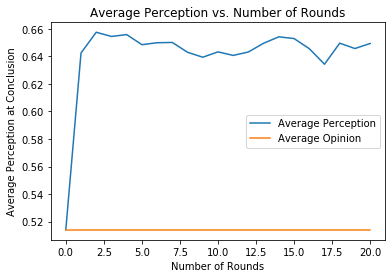

In [27]:
simulate_over_time(network, 20, 9, 3)

## Conclusions
As expected, average perception is higher than actual average opinion, though the perception levels out around .64 pretty quickly. <br> 

This particular notebook demonstrates one of many possible scenarios. Future researchers can modify the network type, probability functions, initial opinion/perception distributions, and other relevant factors to study their impact on network-wide perceptions. Other notebooks in this GitHub repository contain some of these variations, though some are earlier versions, so they may contain bugs or inconsistencies. This notebook is the most organized account of our methodology. <br>

Some possible areas to expand on this work are: 
1. Quantifying the mathematical relationships between perception distributions, probability functions, number of rounds, individual memory, etc.
2. Analyzing the relationship in the above graph more quantitatively, rather than visually, to determine numerical significance.
3. Testing out different probability distributions for opinions and initial perceptions.
4. Testing out network types other than Barabasi-Albert.
5. Making this code more efficient and scalable. 

We hope that others interested in this topic will continue our work. Again, reach out to sammkaiser@wustl.edu if you have any questions.

Ciao!